In [1]:
import sys, os, time, shutil, random
# os.environ['PLETHORA_PATH'] = r'C:\Users\anwan\Documents\workspace\local_data'
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
import torch
from torch import nn, optim as opt
import torch.nn.functional as F
import torch.distributions as distrib
from torch.utils.data import Dataset, DataLoader, TensorDataset

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# from src.helix import helix_labels, helix_observations, ToyVAE
from src.shapes import ShapesVAE, Shapes3D

import omnifig as fig

from omnilearn import util

In [2]:
device = 'cuda'

In [3]:
model = ShapesVAE()
model.load_state_dict(torch.load('model_a.pt'))
model.to(device)

ShapesVAE(
  (encoder): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
      (nonlin): ELU(alpha=1.0)
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
      (nonlin): ELU(alpha=1.0)
    )
    (2): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
      (nonlin): ELU(alpha=1.0)
    )
    (3): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2

In [4]:
# from plethora import datasets
# dataset = datasets.Shapes3D(download=False, mode=None).prepare()
# len(dataset)

In [9]:
# data = Shapes3D(download=False, root=r'C:\Users\anwan\Documents\workspace\local_data\3dshapes')
data = Shapes3D(download=True, root=r'C:\Users\anwan\Documents\workspace\datasets\3dshapes')
# data = Shapes3D(download=False)

Done.


In [13]:
X, _ = data[torch.randint(len(data), size=(20,))]
X.shape

torch.Size([20, 3, 64, 64])

In [14]:
with torch.no_grad():
    Z = model.encode(X.cuda())
    Zmu, Zsigma = Z.loc.cpu(), Z.scale.cpu()
Zmu.shape

RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

In [ ]:
# plt.figure()
# plt.title('Posterior')
# plt.xlabel(f'Dimension {ix}')
# plt.ylabel(f'Dimension {iy}')
# plt.xlim(xvals.min(),xvals.max(),)
# plt.ylim(yvals.min(),yvals.max())
# # plt.imshow(mags, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
# badsel = np.ones((*happy.shape,4))
# badsel[...,-1] = 0.
# badsel[~happy] = [1,0,0,1]
# plt.imshow(badsel, #np.stack([happy, np.ones_like(happy), np.ones_like(happy), ], -1)*255,
# #            cmap='Reds', alpha=0.8, 
#            extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio)
# # plt.imshow(mags);
# plt.tight_layout()


In [38]:
dims = 13, 14
dims = 16, 22
dims

(16, 22)

In [39]:
xlims = -2, 2
ylims = -2, 2
aspect_ratio = 'auto'

In [40]:
zs = Z.sample((10,)).cpu()[...,dims].view(-1,len(dims))
zs.shape

torch.Size([6000, 2])

<IPython.core.display.Javascript object>


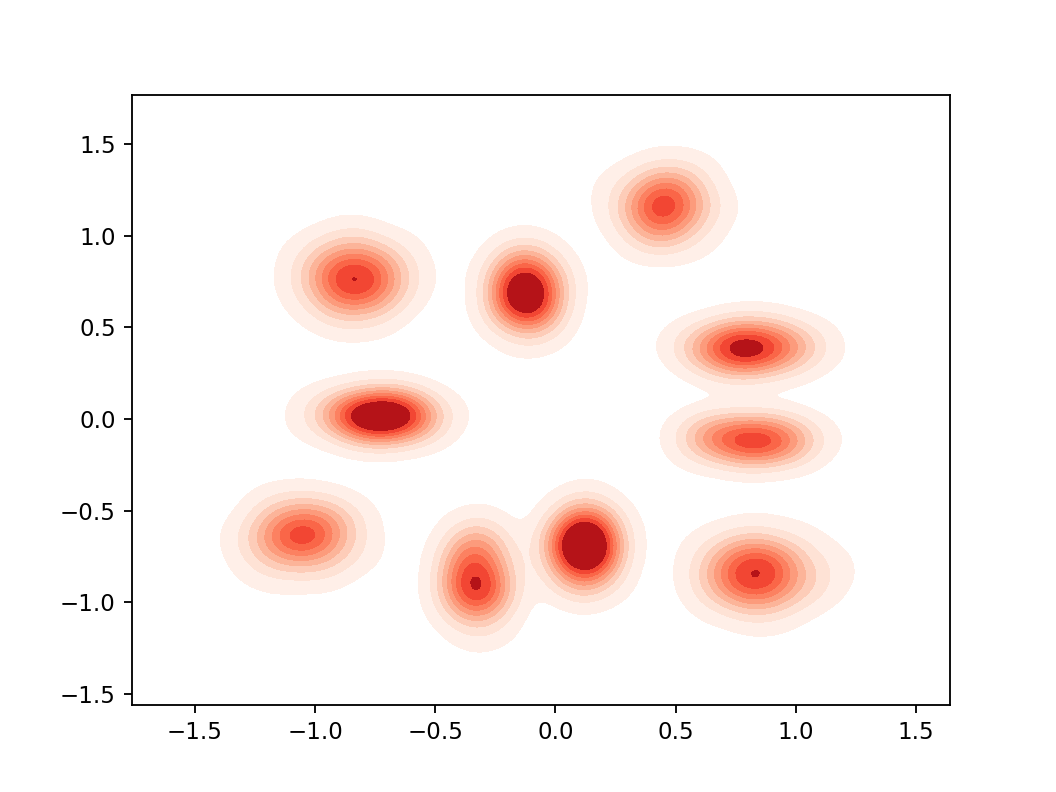

<AxesSubplot:>

In [41]:
plt.figure()
sns.kdeplot(x=zs[...,0], y=zs[...,1], cmap="Reds", shade=True, bw_adjust=.5)

<IPython.core.display.Javascript object>


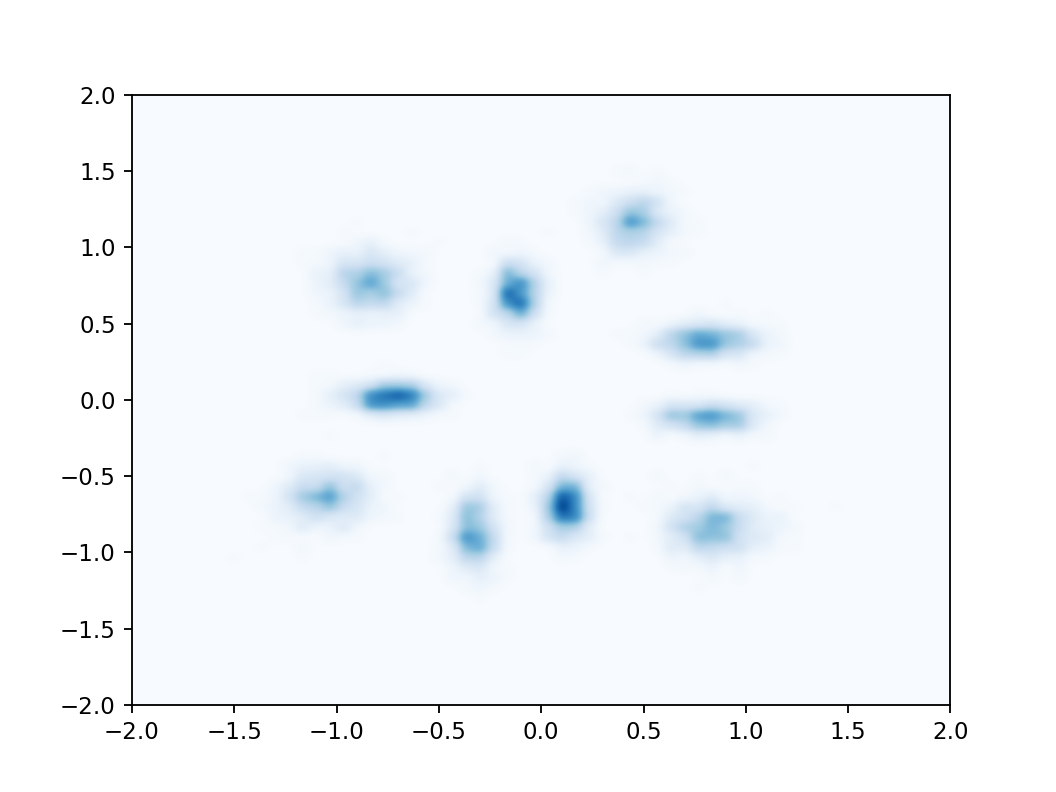

In [42]:
n = 60

plt.figure()
hist, *other = np.histogram2d(*zs.t().numpy(), bins=n, normed=True, range=torch.as_tensor([xlims, ylims]).cpu().numpy())
plt.imshow(hist.T[::-1], cmap='Blues', interpolation = "gaussian", 
           extent=[*xlims, *ylims], aspect=aspect_ratio)

<IPython.core.display.Javascript object>


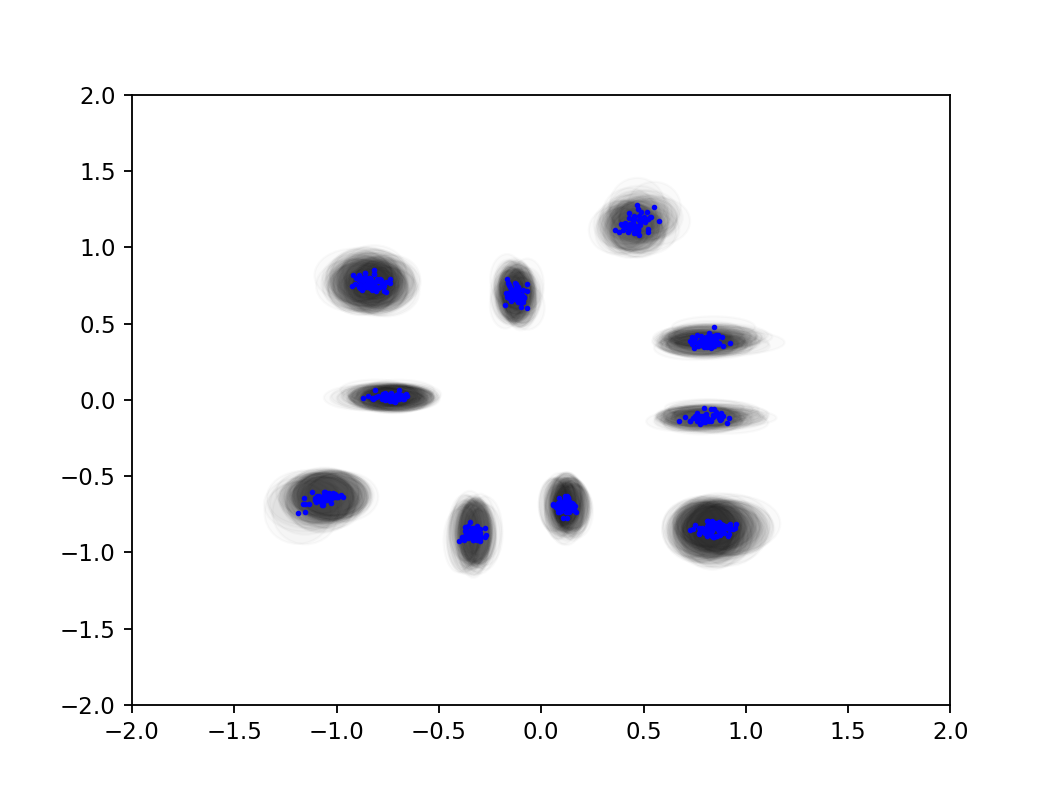

In [44]:
plt.figure()
locs = Zmu[...,dims]
widths = Zsigma[...,dims]*3
# Qlbls = ms.predict(locs.numpy())
for c, s in zip(locs, widths):
    e = mpatches.Ellipse(c, *s, alpha=0.02, color='k')#color=colors[l])
    plt.gca().add_artist(e)
plt.scatter(*locs.t(), marker='o', color='b', s=2, zorder=2)
# plt.scatter(*zs.t(), marker='.', color='C0', s=1, zorder=2)
plt.xlim(*xlims)
plt.ylim(*ylims);